In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
from typing import Callable, Tuple, Any
import numpy as np
from functools import partial
import pdb
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn

2025-05-03 08:44:06.943517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746261846.965242     385 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746261846.971878     385 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the MNIST dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_train, Y_train, X_test, Y_test = jnp.expand_dims(jnp.array(X_train/255), axis=-1), jnp.expand_dims(jnp.array(Y_train), axis=-1), jnp.expand_dims(jnp.array(X_test/255), axis=-1), jnp.expand_dims(jnp.array(Y_test), axis=-1)

In [3]:
Y_train.shape

(60000, 1)

In [4]:
(jnp.ones((4, 1, 3, 3, 128, 1)) @ jnp.ones((1, 16, 1, 1, 1, 8))).shape

(4, 16, 3, 3, 128, 8)

In [5]:
@jax.jit
def get_sample_and_label(idx, inputs, labels):
    return inputs[idx], labels[idx]

arr = jnp.array([32,67,432,2])
xb, yb = jax.vmap(get_sample_and_label, in_axes=(0,None,None))(arr, X_train, Y_train)
xb.shape, yb.shape

((4, 28, 28, 1), (4, 1))

In [8]:
class S6_Unet(nn.Module):
    embed_dim: int = 64
    n_latent_dim: int = 8

    @nn.compact
    def __call__(self, x, h=0):
        # x.shape = (Ba, n_filters, seq_size, hidden_dim)
        _, h, w, hidden_dim = x.shape
        Ba = x.shape[0]
        # A = -1* self.param('A', nn.initializers.ones, (1,  self.n_latent_dim, self.embed_dim , self.embed_dim))
        B = self.param('B', nn.initializers.ones, (1, self.n_latent_dim, 1, 1, 1, self.embed_dim))
        C = self.param('C', jax.random.normal, (1,  h, w, self.embed_dim, 1))
        D = self.param('D', nn.initializers.ones, (1, self.n_latent_dim, 1, 1, 1, self.embed_dim))
        S = -0.5* self.param('S', nn.initializers.ones, (1, self.n_latent_dim, 1, 1, 1, self.embed_dim))
        # h = h*jnp.ones((Ba,  self.n_latent_dim, hidden_dim, self.embed_dim))
        return self.ssm(x, B, C, D, S)
        
    def ssm(self, x, B, C, D, S):
        def compute_delta(x, B):
            # State update: (B, n, 3, 3, D, H) <- (B, 1, 3, 3, D, H) @ (1, n, 1, H, H)
            # state_contribution = nn.RMSNorm()(state@A)
            # Input contribution: (B, n, 3, 3, D, H) <- (B, 1, 3, 3, D, 1) @ (1, n, 1, 1, 1, H)
            input_contribution = x@B
            # print("state_contribution + input_contribution: ", state_contribution.sum(), input_contribution.sum())
            return input_contribution

#         for k in range(x.shape[-1]):
#             # Compute ∆, the state update candidates
# #             pdb.set_trace()
#             # print("k: ", k)
        delta = compute_delta(jnp.expand_dims(x, axis=(1,5)), B)
        #h: (B, 3, 3, D, H) <- (B, n, 3, 3, D, H)*((B, 1, 3, 3, D, 1) @ (1, n, 1, 1, 1, H))
        h = delta*(jnp.expand_dims(x, axis=(1,5))@S)
            # print("h sum:", h.min(), h.max(), jnp.sum(h))
        # pdb.set_trace()
        #y: (B, N, D, 1) <- (B, N, D, H) @ (1, N, H, 1) + (B, 1, D, 1)*(1, N, D, 1)
        # y = h @ C + jnp.expand_dims(x[:,-1,:], axis=(1,3))*D
        #h: (B, n, 3, 3, D, 1) <- (B, n, 3, 3, D, H) @ (1, n, 3, 3, H, 1) + (B, 1, 3, 3, D, 1) @ (1, n, 1, 1, 1, H)
        h = h @ C + jnp.expand_dims(x, axis=(1,5))@D
        return jnp.einsum('bnhwd1->bhwd', h)

In [9]:
class VisionEncoder(nn.Module):
    patch_size: int = 2
    hidden_dim: int = 64

    @nn.compact
    def __call__(self, x):
        # Assuming input shape: (batch, height, width, channels)
        # Patch embedding

########################################################################################################################################

        for i in range(3):
            x = nn.Conv(
                features=self.hidden_dim*(2**i),
                kernel_size=(self.patch_size, self.patch_size),
                strides=(1, 1)
                )(x)

            x = nn.max_pool(x, window_shape=(self.patch_size, self.patch_size), strides=(self.patch_size, self.patch_size))

        print("After conv", x.shape)
        # x = x.reshape(x.shape[0], -1, x.shape[-1])
        # print("After reshape",x.shape)
        h = S6_Unet()(jax.nn.silu(nn.RMSNorm()(x)))
        print("After S6", h.shape)
        
        return nn.Dense(10)(h.reshape(h.shape[0], -1, h.shape[-1])), h
########################################################################################################################################



########################################################################################################################################
        # x = jax.nn.silu(nn.Conv(features=64, kernel_size=(self.patch_size, self.patch_size))(x))
        # print("After first conv: ", x.shape)
        # x = nn.max_pool(x, window_shape=(2, 2), strides=(self.patch_size, self.patch_size))
        # print("After first max pool: ", x.shape)
        # x = jax.nn.silu(nn.Conv(features=128, kernel_size=(self.patch_size, self.patch_size))(x))
        # print("After 2nd conv: ", x.shape)
        # x = nn.max_pool(x, window_shape=(2, 2), strides=(self.patch_size, self.patch_size))
        # print("After 2nd max pool: ", x.shape)
        # x = jax.nn.silu(nn.Conv(features=256, kernel_size=(self.patch_size, self.patch_size))(x))
        # print("After 3rd conv: ", x.shape)
        # x = x.reshape(x.shape[0], -1)  # flatten
        # print("After flatten: ", x.shape)
        # x = jax.nn.silu(nn.Dense(256)(x))
########################################################################################################################################

########################################################################################################################################
        # # Flatten patches
        # x =x.reshape(x.shape[0], -1, x.shape[-1])

        # # Transformer blocks
        # for _ in range(6):  # 6 layers
        #     x = nn.MultiHeadDotProductAttention(
        #         num_heads=8,
        #         qkv_features=self.hidden_dim
        #     )(x)
        #     x = nn.LayerNorm()(x)

        # # Projection to embedding dimension
        # x = jax.nn.silu(nn.Dense(self.embed_dim)(jax.nn.silu(x.mean(axis=1))))
########################################################################################################################################

        # x = nn.Dense(10)(x)
        # return jnp.expand_dims(x, axis=1)

model = VisionEncoder()
params = model.init(jax.random.PRNGKey(451),jnp.ones((1,28,28,1)))
n_params = sum(p.size for p in jax.tree_util.tree_leaves(params))
print(f"Total number of parameters: {n_params:_}")


After conv (1, 3, 3, 256)
After S6 (1, 3, 3, 256)
Total number of parameters: 169_482


In [10]:
finl, hdn = model.apply(params,jnp.ones((1,28,28,1)))
print(finl.shape, hdn.shape)

After conv (1, 3, 3, 256)
After S6 (1, 3, 3, 256)
(1, 9, 10) (1, 3, 3, 256)


In [11]:
# opt = optax.sgd(learning_rate, momentum)
opt = optax.adamw(learning_rate=0.001)


opt_state = opt.init(params)

In [12]:
def loss_fun(params, x, y):
    logits, _ = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

@jax.jit
def eval_step(params, x, y):
    logits, _ = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

In [13]:
%%time
key = jax.random.PRNGKey(42)  # Replace 42 with any random seed
BATCH_SIZE = 64
learning_rate = 0.1
momentum = 0.9
train_length = len(X_train)//BATCH_SIZE
kernel_s = 2
eval_iters = 1000

all_train_losses = []
all_eval_losses = []

all_train_accuracy =  []
all_test_accuracy = []

eval_iters = 50000

@jax.jit
def step(idx, params, opt_state):
    xb, yb = jax.vmap(get_sample_and_label, in_axes=(0,None,None))(idx, X_train, Y_train)
    (loss, train_accuracy), grad = jax.value_and_grad(loss_fun, has_aux=True)(params, xb, yb)
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, train_accuracy

for i in range(eval_iters):
    key, subkey = jax.random.split(key)
    iix = jax.random.randint(subkey, shape=(BATCH_SIZE,), minval=0, maxval=len(X_train))
    params, opt_state, loss, train_accuracy = step(iix, params, opt_state)

    # once every N_FREQ_EVAL we compute loss on the validation set
    if i%100 == 0:
        key, subkey = jax.random.split(key)
        indxs = jax.random.randint(subkey, shape=(BATCH_SIZE,), minval=0, maxval=len(X_test))
        xt, yt = jax.vmap(get_sample_and_label, in_axes=(0,None,None))(indxs, X_test, Y_test)
        eval_loss, eval_accuracy = eval_step(params, xt, yt)
        all_train_losses.append(loss)
        all_eval_losses.append(eval_loss)
        all_train_accuracy.append(train_accuracy)
        all_test_accuracy.append(eval_accuracy)
        print('####################################################################################################')
        print("Step: ", i,"\t\t Train Loss: ", format(loss, ".6f"),"\t\t Train Accuracy: ", format(train_accuracy, ".2%"))
        print("Step: ", i,"\t\t Eval Loss: ", format(eval_loss, ".6f"),"\t\t Eval Accuracy: ", format(eval_accuracy, ".2%"))

After conv (64, 3, 3, 256)
After S6 (64, 3, 3, 256)
After conv (64, 3, 3, 256)
After S6 (64, 3, 3, 256)
####################################################################################################
Step:  0 		 Train Loss:  2100.134277 		 Train Accuracy:  11.98%
Step:  0 		 Eval Loss:  2431.779297 		 Eval Accuracy:  9.72%
####################################################################################################
Step:  100 		 Train Loss:  28.293940 		 Train Accuracy:  34.03%
Step:  100 		 Eval Loss:  34.204803 		 Eval Accuracy:  36.81%
####################################################################################################
Step:  200 		 Train Loss:  25.722145 		 Train Accuracy:  32.47%
Step:  200 		 Eval Loss:  23.316725 		 Eval Accuracy:  33.68%
####################################################################################################
Step:  300 		 Train Loss:  13.613439 		 Train Accuracy:  43.58%
Step:  300 		 Eval Loss:  10.766545 		 Eval Accurac

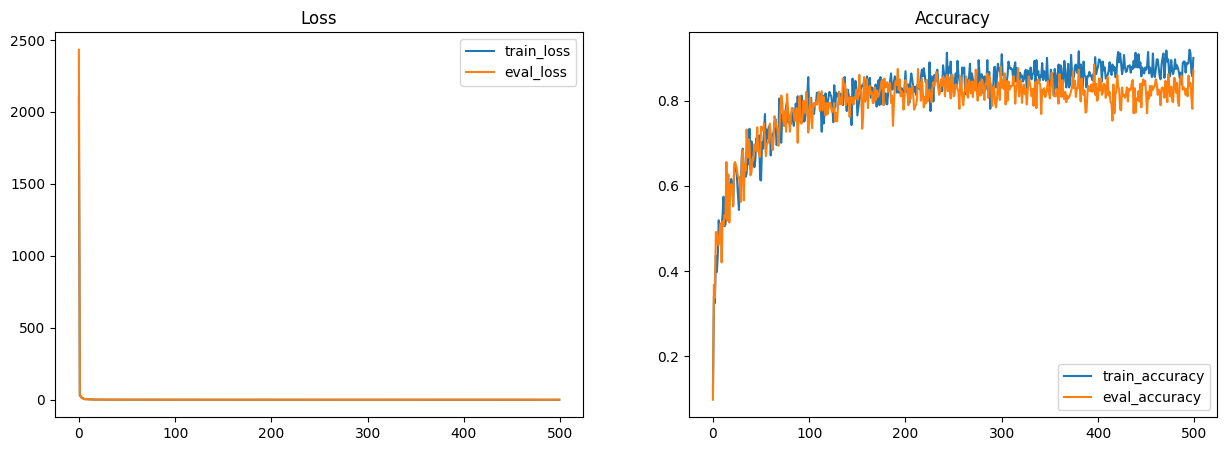

<Figure size 640x480 with 0 Axes>

In [14]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')



ax1.plot(all_train_losses, label='train_loss')
ax1.plot(all_eval_losses, label='eval_loss')

ax2.plot(all_train_accuracy, label='train_accuracy')
ax2.plot(all_test_accuracy, label='eval_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [15]:
asfdghywqdw

NameError: name 'asfdghywqdw' is not defined

In [ ]:
# Define the Text Encoder
class TextEncoder(nn.Module):
    embed_dim: int = 128
    vocab_size: int = 10
    max_length: int = 77

    @nn.compact
    def __call__(self, x):
        # x shape: (batch, sequence_length)
        x = nn.Embed(self.vocab_size, self.embed_dim)(x)

        x = S6_Unet()(nn.RMSNorm()(x))

        # Transformer blocks
        for _ in range(6):
            x = nn.MultiHeadDotProductAttention(
                num_heads=8,
                qkv_features=self.embed_dim
            )(x)
            x = nn.LayerNorm()(x)

        # Projection to embedding dimension
        x = nn.Dense(self.embed_dim)(x[:, 0])  # Take CLS token
        return x

In [ ]:
key = jax.random.PRNGKey(42)
# x = jnp.expand_dims(xb[0],axis=0)
x = jnp.ones((64,20), dtype=jnp.int64)

model = TextEncoder()

params = model.init(jax.random.PRNGKey(45),x)
print(params.keys())
n_params = sum(p.size for p in jax.tree_util.tree_leaves(params))

print(f"Total number of parameters: {n_params:_}")

output = model.apply(params, x)
print(output.shape)

In [ ]:
params['params']['Embed_0']['embedding'].shape